In [94]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [95]:
r = requests.get('https://api.curve.fi/api/getWeeklyFees')
data = r.json()['data']
distf = pd.DataFrame(data['weeklyFeesTable'])
distf['ts'] = distf['ts'].astype(int) // 1000
distf['ts'] = pd.to_datetime(distf['ts'],unit='s')
distf

,date,ts,rawFees
0,Thu Jul 14 2022,2022-07-14,621178.20
1,Thu Jul 07 2022,2022-07-07,288186.75
2,Thu Jun 30 2022,2022-06-30,520551.08
3,Thu Jun 23 2022,2022-06-23,4397252.91
4,Thu Jun 16 2022,2022-06-16,737122.69
...,...,...,...
91,Thu Oct 15 2020,2020-10-15,274578.78
92,Thu Oct 08 2020,2020-10-08,274578.78
93,Thu Oct 01 2020,2020-10-01,274578.78
94,Thu Sep 24 2020,2020-09-24,274578.78


In [96]:
total_rev = distf[['ts', 'rawFees']]
total_rev = total_rev.set_index('ts')
total_rev

,rawFees
ts,
2022-07-14,621178.20
2022-07-07,288186.75
2022-06-30,520551.08
2022-06-23,4397252.91
2022-06-16,737122.69
...,...
2020-10-15,274578.78
2020-10-08,274578.78
2020-10-01,274578.78


In [97]:
ENDPOINT = 'https://api.thegraph.com/subgraphs/name/convex-community/sidechain-fees-'
networks = ['matic', 'arbitrum', 'avalanche', 'fantom']

In [98]:
QUERY = """{
  bridgedFeesRecords(first: 1000) {
    value
    week
  }
}
"""

In [99]:
def grt_query(endpoint, query):
    r = requests.post(endpoint, json={'query': query})
    return r.json()['data']

In [100]:
res = []
for network in networks:
    endpoint = ENDPOINT + network
    g_data = grt_query(endpoint, QUERY)['bridgedFeesRecords']
    df = pd.DataFrame(g_data)
    df['week'] = pd.to_datetime(df['week'],unit='s')
    df['value'] = df['value'].astype(float)
    df.columns = [network, 'week']
    res.append(df.groupby('week').sum())

In [101]:
data = res[0]
for i in range(len(res)-1):
    data = pd.merge(data, res[i+1], how='outer',left_index=True,right_index=True)

In [102]:
sidechain_rev = data.fillna(0).sort_index()
sidechain_rev

,matic,arbitrum,avalanche,fantom
week,,,,
2021-11-11,33885.71,0.00,0.00,46467.30
2021-11-18,0.00,0.00,0.00,228732.46
2021-11-25,98003.98,0.00,0.00,49847.26
2021-12-02,100968.29,0.00,0.00,57555.85
2021-12-09,59113.34,478190.00,0.00,54838.33
2021-12-16,34595.75,22237.47,107333.23,34686.58
2021-12-23,64361.01,18258.86,60405.14,22687.74
2021-12-30,47813.34,18279.39,72477.55,28602.99
2022-01-06,56483.30,32725.57,68717.34,39793.92


In [110]:
sidechain_rev[sidechain_rev.columns].sum()

matic       1576032.95
arbitrum    1108446.34
avalanche   1816485.57
fantom      1422167.05
dtype: float64

In [103]:
sidechain_rev[sidechain_rev.columns].sum(axis=1)

week
2021-11-11    80353.01
2021-11-18   228732.46
2021-11-25   147851.23
2021-12-02   158524.14
2021-12-09   592141.67
2021-12-16   198853.02
2021-12-23   165712.75
2021-12-30   167173.27
2022-01-06   197720.13
2022-01-13   191925.52
2022-01-20   384689.87
2022-01-27   259388.84
2022-02-03   149488.04
2022-02-10   153042.25
2022-02-17   136945.94
2022-02-24   234484.64
2022-03-03   123121.43
2022-03-10    70341.44
2022-03-17   121984.00
2022-03-24    91218.97
2022-03-31    74424.04
2022-04-07   385034.30
2022-04-14   287080.25
2022-04-21   117029.00
2022-04-28   106252.10
2022-05-05   154517.97
2022-05-12   361005.68
2022-05-19    21291.68
2022-05-26   137419.39
2022-06-02    24539.74
2022-06-09   150916.31
2022-06-16    96778.03
2022-06-23    33657.52
2022-06-30    37277.41
2022-07-14    82215.87
dtype: float64

In [104]:
mainnet_fees_only = (total_rev['rawFees'] - sidechain_rev[sidechain_rev.columns].sum(axis=1)).dropna()

In [105]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [106]:
total_rev_data = pd.merge(sidechain_rev, pd.DataFrame(mainnet_fees_only, columns=['mainnet']), how='outer', right_index=True, left_index=True)
total_rev_data

,matic,arbitrum,avalanche,fantom,mainnet
week,,,,,
2021-11-11,33885.71,0.00,0.00,46467.30,1098993.59
2021-11-18,0.00,0.00,0.00,228732.46,1270900.05
2021-11-25,98003.98,0.00,0.00,49847.26,1739832.28
2021-12-02,100968.29,0.00,0.00,57555.85,2535059.33
2021-12-09,59113.34,478190.00,0.00,54838.33,1397736.49
2021-12-16,34595.75,22237.47,107333.23,34686.58,1455275.14
2021-12-23,64361.01,18258.86,60405.14,22687.74,1256964.07
2021-12-30,47813.34,18279.39,72477.55,28602.99,1366063.91
2022-01-06,56483.30,32725.57,68717.34,39793.92,1425149.83


In [107]:
[ENDPOINT + network for network in networks]

['https://api.thegraph.com/subgraphs/name/convex-community/sidechain-fees-matic',
 'https://api.thegraph.com/subgraphs/name/convex-community/sidechain-fees-arbitrum',
 'https://api.thegraph.com/subgraphs/name/convex-community/sidechain-fees-avalanche',
 'https://api.thegraph.com/subgraphs/name/convex-community/sidechain-fees-fantom']

<AxesSubplot:title={'center':'Weekly Curve fees by chain since Nov. 2021'}, xlabel='week'>

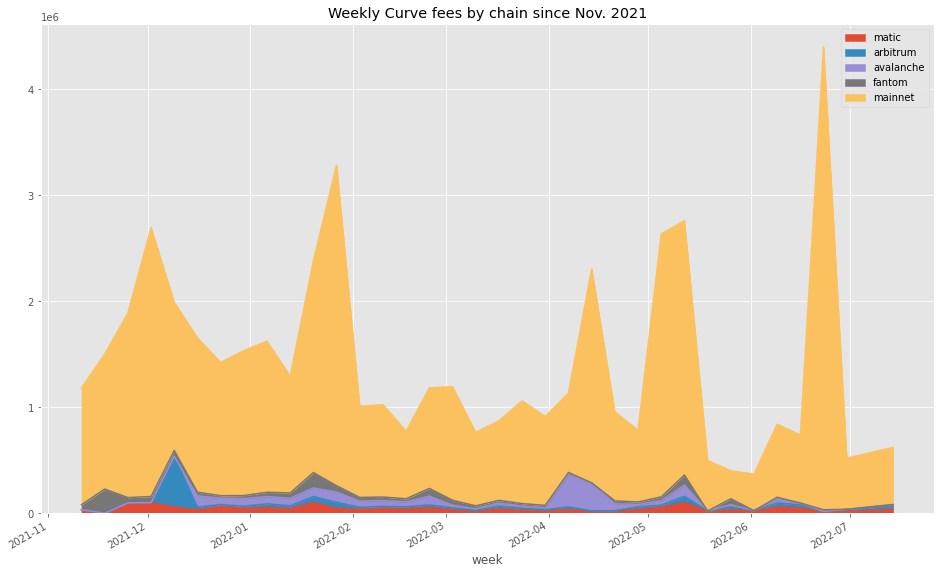

In [108]:
total_rev_data.plot.area(figsize=(16, 10), title="Weekly Curve fees by chain since Nov. 2021")

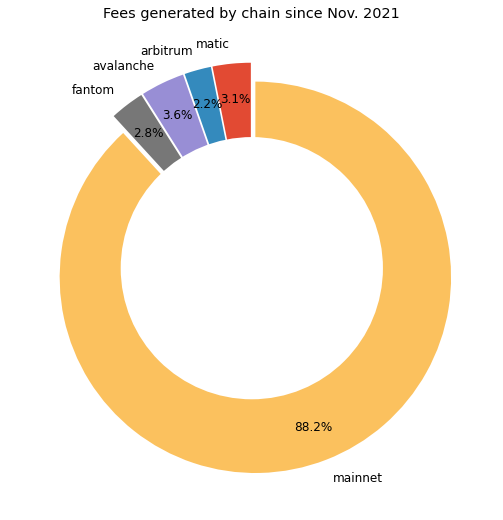

In [109]:
ax = total_rev_data.sum().plot.pie(title='Fees generated by chain since Nov. 2021', autopct='%1.1f%%', figsize=(9,9), fontsize=12, startangle=90, pctdistance=0.82, explode=(len(networks)+1)*[0.05])
ax.set_ylabel('')
centre_circle = plt.Circle((0,0),0.67,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)